Data analysis for PLR-3000 data
===============================

After bluetoothing accross, open the excel spreadsheet and save it in CSV format. Then run the code below.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('paper', font_scale=1.5)
sns.set_style('whitegrid')
#plr3000 = pd.read_csv(
#    r'C:/Users/engs2242/Desktop/PLR-3000/R_20210312_132224.csv')

plr3000 = pd.read_csv(
    r'../examples/PFR/data/neuroptics/R_20210728_111624.csv')

In [2]:
plr3000

,Record ID,Device ID,Patient ID,Time,MeasurementType,Pupil Measured,ABN,Static Measurement Duration,Static Led in uW,Static Mean,...,Unnamed: 824,Unnamed: 825,Unnamed: 826,Unnamed: 827,Unnamed: 828,Unnamed: 829,Unnamed: 830,Unnamed: 831,Unnamed: 832,Unnamed: 833
0,238,3PK200021,3,27/07/2021 09:38,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
1,237,3PK200021,3,27/07/2021 09:38,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
2,236,3PK200021,3,27/07/2021 09:37,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
3,235,3PK200021,3,27/07/2021 09:36,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
4,234,3PK200021,3,27/07/2021 09:36,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,124,3PK200021,0,29/03/2021 13:04,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
81,123,3PK200021,0,29/03/2021 13:02,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
82,122,3PK200021,0,29/03/2021 12:58,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1
83,121,3PK200021,0,29/03/2021 12:56,1,Right,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,1,1


Seperate raw data from summary information
------------------------------------------

In [3]:
info = []
raw_data = []
for idx, row in plr3000.iterrows():
    information = row[[col for col in plr3000.columns if not 'Unnamed' in col]]
    raw = row[[col for col in plr3000.columns if 'Unnamed' in col]]
    dl = information['Data Length']
    time = raw.iloc[0:dl].to_numpy()
    pupil = raw.iloc[dl:dl*2].to_numpy()
    valid = raw.iloc[dl*2:dl*3].to_numpy()
    df = pd.DataFrame({'onset': time,
                       'diameter': pupil,
                       'valid': valid}, dtype=float)
    df['Record ID'] = information['Record ID']
    df['Patient ID'] = information['Patient ID']
    df['uW'] = information['PLR Pulse Led in uW']
    raw_data.append(df)
    info.append(information.to_frame().T)

info = pd.concat(info).set_index(['Record ID'])
raw_data = pd.concat(raw_data).set_index(['Record ID', 'onset'])
# set invalid samples to nan
raw_data.loc[raw_data.valid==0, 'diameter'] = np.nan
raw_data['diameter_pc'] = ((raw_data['diameter']/info['PLR Diameter Init'])-1) *100
neuroptics = raw_data.reset_index().rename(
    columns={'Record ID':'rec',
             'Patient ID':'Subject',
             'diameter':'pupil'})
neuroptics.onset = neuroptics.onset-1
neuroptics.loc[neuroptics.Subject==0, 'Subject'] += 1
neuroptics['Subject'] = 'sub00' + neuroptics['Subject'].astype('str')
neuroptics['Device'] = 'PLR-3000'
neuroptics

,rec,onset,pupil,valid,Subject,uW,diameter_pc,Device
0,238,-1.000,7.381,1.0,sub003,180,-0.256757,PLR-3000
1,238,-0.967,7.363,1.0,sub003,180,-0.5,PLR-3000
2,238,-0.933,7.366,1.0,sub003,180,-0.459459,PLR-3000
3,238,-0.900,7.315,1.0,sub003,180,-1.148649,PLR-3000
4,238,-0.866,7.363,1.0,sub003,180,-0.5,PLR-3000
...,...,...,...,...,...,...,...,...
22945,120,7.857,4.500,1.0,sub001,180,0.0,PLR-3000
22946,120,7.890,4.456,1.0,sub001,180,-0.977778,PLR-3000
22947,120,7.924,4.497,1.0,sub001,180,-0.066667,PLR-3000
22948,120,7.957,4.482,1.0,sub001,180,-0.4,PLR-3000


In [4]:
neuroptics.valid.value_counts()

1.0    22948
0.0        2
Name: valid, dtype: int64

<AxesSubplot:xlabel='onset'>

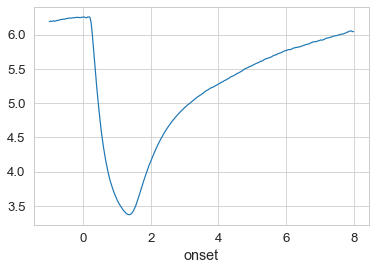

In [12]:
neuroptics.groupby(by=['onset'])['pupil'].mean().plot()

In [4]:
import os
import os.path as op
import pandas as pd

datapath = r'../examples/PFR/data/pyplr'
subs = os.listdir(datapath)
cols = ['diameter','diameter_3d','timestamp','confidence']
trials=[]
for sub in subs:
    subpath = op.join(datapath, sub)
    for rec in os.listdir(subpath):
        recpath = op.join(subpath, rec)
        data = pd.read_csv(op.join(recpath, 'raw_data.csv'), index_col='timestamp', usecols=cols)
        data['onset'] =  range(len(data))
        data['onset'] =  data['onset'] * 1/120-1
        data['Subject'] = sub
        data['rec'] = rec
        trials.append(data.reset_index())
        
trials = pd.concat(trials).reset_index(drop=True).rename(columns={'index':'onset'})
trials = trials.sort_values(['Subject','rec'])
trials

,timestamp,diameter,confidence,diameter_3d,onset,Subject,rec
60480,1541.458415,45.774245,0.983601,5.515972,-1.000000,sub001,rec000
60481,1541.466367,43.318788,0.057888,5.533923,-0.991667,sub001,rec000
60482,1541.474436,39.485776,0.711115,5.549734,-0.983333,sub001,rec000
60483,1541.482452,42.277045,0.739466,5.564221,-0.975000,sub001,rec000
60484,1541.490535,44.399923,0.927758,5.577575,-0.966667,sub001,rec000
...,...,...,...,...,...,...,...
8635,-243029.601710,47.412539,1.000000,4.660408,7.958333,sub003,rec020
8636,-243029.593881,47.537248,1.000000,4.665197,7.966667,sub003,rec020
8637,-243029.585697,47.514435,1.000000,4.670406,7.975000,sub003,rec020
8638,-243029.577903,47.500145,1.000000,4.676048,7.983333,sub003,rec020


In [5]:
rec = ['rec' + str(i).zfill(3) for i in range(21)]

trials.rename(columns={'diameter_3d':'Pupil Core'}, inplace=True)
trials = trials.melt(
    value_vars=['Pupil Core'],
    id_vars=['Subject','rec','onset'],
    value_name='pupil',
    var_name='Device')
trials = trials[trials.Subject!='sub001_old']
trials = trials[trials.rec.isin(rec)]

In [6]:

data = neuroptics.loc[neuroptics.uW==180].append(trials[['rec', 'onset', 'pupil', 'Subject', 'Device']])
#data = data[data.Method!='Pupil Labs (px)']
data = data.replace({'sub001':'1','sub002':'2', 'sub003': '3'})
data

,rec,onset,pupil,valid,Subject,uW,diameter_pc,Device
0,238,-1.000000,7.381000,1.0,3,180.0,-0.256757,PLR-3000
1,238,-0.967000,7.363000,1.0,3,180.0,-0.500000,PLR-3000
2,238,-0.933000,7.366000,1.0,3,180.0,-0.459459,PLR-3000
3,238,-0.900000,7.315000,1.0,3,180.0,-1.148649,PLR-3000
4,238,-0.866000,7.363000,1.0,3,180.0,-0.500000,PLR-3000
...,...,...,...,...,...,...,...,...
71275,rec020,7.958333,4.660408,NaN,3,NaN,NaN,Pupil Core
71276,rec020,7.966667,4.665197,NaN,3,NaN,NaN,Pupil Core
71277,rec020,7.975000,4.670406,NaN,3,NaN,NaN,Pupil Core
71278,rec020,7.983333,4.676048,NaN,3,NaN,NaN,Pupil Core


In [7]:
data = data.sort_values('Subject')

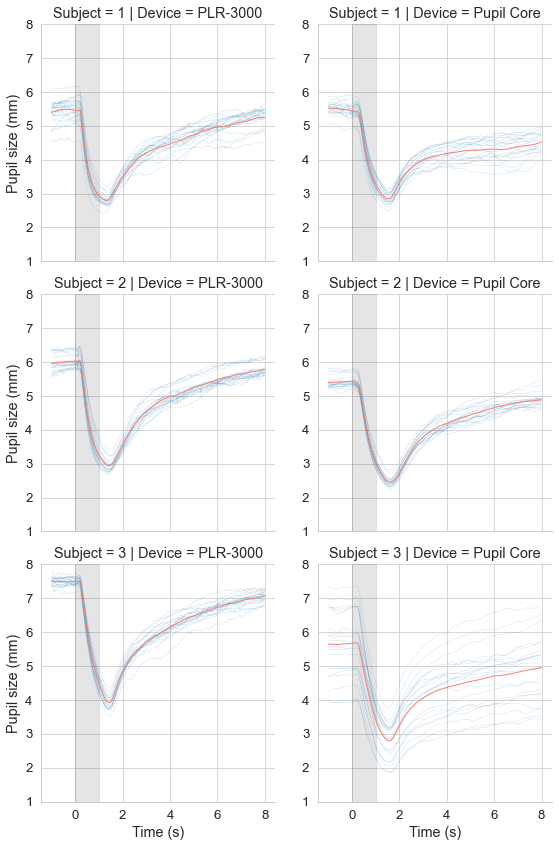

In [8]:
order = ['PLR-3000', 'Pupil Core']
g = sns.FacetGrid(data=data, row='Subject', col='Device', sharey=False, row_order=['1','2', '3'], margin_titles=False, height=4, col_order=order)
g.map_dataframe(sns.lineplot, x='onset', y='pupil', estimator=None, units='rec', lw=.1)
g.map_dataframe(sns.lineplot, x='onset', y='pupil', ci=None, lw=1, color='salmon')

axs = [ax for sublist in g.axes for ax in sublist]
for i, ax in enumerate(axs):
    ax.axvspan(0,1,color='k', alpha=.1)
    ax.set_xlabel('Time (s)')
    ax.set_ylim((1,8))
    if i%2 == 0:
        ax.set_ylabel('Pupil size (mm)')

g.savefig('../img/PLR-3000-Pupil-Core-PLRs.tiff', dpi=300)

In [9]:
data

,rec,onset,pupil,valid,Subject,uW,diameter_pc,Device
18899,rec017,3.491667,3.891640,NaN,1,NaN,NaN,Pupil Core
9717,rec008,7.975000,4.269477,NaN,1,NaN,NaN,Pupil Core
9718,rec008,7.983333,4.268333,NaN,1,NaN,NaN,Pupil Core
9719,rec008,7.991667,4.267190,NaN,1,NaN,NaN,Pupil Core
9720,rec009,-1.000000,5.389712,NaN,1,NaN,NaN,Pupil Core
...,...,...,...,...,...,...,...,...
52553,rec003,4.941667,5.648846,NaN,3,NaN,NaN,Pupil Core
52552,rec003,4.933333,5.647115,NaN,3,NaN,NaN,Pupil Core
52551,rec003,4.925000,5.645350,NaN,3,NaN,NaN,Pupil Core
52562,rec003,5.016667,5.665735,NaN,3,NaN,NaN,Pupil Core


In [10]:
cols = ['PLR Diameter Init', 'PLR Diameter End', 'PLR Latency',
       'PLR Constriction Velocity', 'PLR Max Constriction Velocity',
       'PLR Dilation Velocity', 'PLR T75']
info[cols] = info[cols].astype('float')
info.groupby('Patient ID')[cols].agg('mean')


,PLR Diameter Init,PLR Diameter End,PLR Latency,PLR Constriction Velocity,PLR Max Constriction Velocity,PLR Dilation Velocity,PLR T75
Patient ID,,,,,,,
0,5.620,3.050,0.22425,-3.8615,-6.23275,1.090256,3.28973
2,6.020,2.935,0.22850,-3.4690,-5.76900,1.139500,3.55650
3,7.448,4.104,0.21960,-3.5024,-5.40000,1.290000,3.76880


In [11]:
info.groupby('Patient ID')[cols].agg('std')

,PLR Diameter Init,PLR Diameter End,PLR Latency,PLR Constriction Velocity,PLR Max Constriction Velocity,PLR Dilation Velocity,PLR T75
Patient ID,,,,,,,
0,0.353154,0.347150,0.014656,0.519914,0.466663,0.164868,1.062671
2,0.206729,0.184320,0.006708,0.222590,0.393231,0.170309,0.548800
3,0.153080,0.428641,0.018138,0.253283,0.402978,0.207646,0.835012


In [12]:
info.loc[info['Patient ID']==3, 'PLR T75']

Record ID
238    5.38
237    4.08
236    4.48
235    3.48
234    3.84
233    4.75
232    3.94
231    3.91
230    4.68
229    3.71
228    3.84
227    4.28
226    4.08
225    3.54
224    4.48
223    3.81
222    4.51
221    3.58
220    4.11
219    3.84
186    2.74
185    2.07
184    2.17
182    2.31
181    2.61
Name: PLR T75, dtype: float64

In [13]:
from pyplr.plr import PLR

params = []
plrs = []

for idxs, df in trials.groupby(['Subject', 'rec']):
    data = df.loc[df.Device=='Pupil Core', 'pupil'].to_numpy()
    plrs.append(data)
    plr = PLR(data, sample_rate=120, onset_idx=120, stim_duration=1)
    parameters = plr.parameters().T
    parameters[['Subject', 'Rec']] = idxs
    params.append(parameters)
params = pd.concat(params).set_index(['Subject', 'Rec'])
params['T2Rec75pc'] = params['T2Rec75pc'].replace(0., np.nan)
params

Baseline  Latency_a  Latency_b  T2MaxVel  T2MaxCon  T2Rec75pc  \
Subject Rec                                                                     
sub001  rec000  5.573743   0.341667   0.291667  0.500000  1.541667        NaN   
        rec001  5.552783   0.300000   0.333333  0.425000  1.558333        NaN   
        rec002  5.587755   0.416667   0.075000  0.458333  1.566667        NaN   
        rec003  5.616102   0.308333   0.383333  0.475000  1.550000        NaN   
        rec004  5.623108   0.300000   0.316667  0.458333  1.533333        NaN   
...                  ...        ...        ...       ...       ...        ...   
sub003  rec016  5.342419   0.275000   0.275000  0.383333  1.558333        NaN   
        rec017  6.632500   0.283333   0.291667  0.375000  1.550000        NaN   
        rec018  6.658618   0.275000   0.275000  0.358333  1.558333        NaN   
        rec019  6.692014   0.300000   0.300000  0.691667  1.558333        NaN   
        rec020  6.066479   0.258333   0.250000  0.391667  1.591667        NaN   

                 PeakCon  ConAmplitude  VelConMax  VelConAve   AccConMax  \
Subject Rec                                                                
sub001  rec000  3.099868      2.473876   4.060254   2.004233   61.760663   
        rec001  3.137805      2.414978   4.263885   1.927802   33.331619   
        rec002  3.021226      2.566529   4.865049   1.893880  187.839407   
        rec003  2.996566      2.619536   4.292455   2.036843   43.350247   
        rec004  3.033023      2.590085   4.424024   2.090126   30.169277   
...                  ...           ...        ...        ...         ...   
sub003  rec016  2.527366      2.815053   4.291677   2.135077   29.155987   
        rec017  3.210078      3.422422   5.616875   2.725579   56.260786   
        rec018  3.117304      3.541314   5.921992   2.760833   61.187004   
        rec019  3.129024      3.562991   5.689882   2.818665   57.068146   
        rec020  2.783099      3.283380   5.387388   2.419486   32.921571   

                 ConTime  VelRedAve  VelRedMax  AccRedMax  
Subject Rec                                                
sub001  rec000  1.200000   0.334600   1.525863  10.228737  
        rec001  1.258333   0.461672   1.358180   8.016828  
        rec002  1.150000   0.373516   1.579248  11.457333  
        rec003  1.241667   0.406475   1.748234   7.486726  
        rec004  1.233333   0.334027   1.522148   8.695466  
...                  ...        ...        ...        ...  
sub003  rec016  1.283333   0.284291   1.123619  14.436087  
        rec017  1.266667   0.421054   1.694090   8.329350  
        rec018  1.283333   0.455514   1.680902   9.953117  
        rec019  1.258333   0.471282   1.867254  13.380611  
        rec020  1.333333   0.383792   1.267917  10.519463  

[63 rows x 15 columns]

In [14]:
params.groupby(level=[0]).agg('mean')

,Baseline,Latency_a,Latency_b,T2MaxVel,T2MaxCon,T2Rec75pc,PeakCon,ConAmplitude,VelConMax,VelConAve,AccConMax,ConTime,VelRedAve,VelRedMax,AccRedMax
Subject,,,,,,,,,,,,,,,
sub001,5.487081,0.231746,0.301190,0.440079,1.536508,5.808333,2.847437,2.639645,4.649154,1.958865,45.904388,1.304762,0.352802,1.501811,9.272317
sub002,5.407481,0.210714,0.309524,0.427778,1.607937,4.410417,2.457270,2.950211,4.550452,2.105594,36.164056,1.397222,0.409973,1.398711,7.448599
sub003,5.640402,0.282540,0.285317,0.443254,1.570635,5.005128,2.785373,2.855029,4.127821,2.197156,32.658116,1.288095,0.369028,1.546525,10.552869


In [15]:
params.groupby(level=[0]).agg('std')

,Baseline,Latency_a,Latency_b,T2MaxVel,T2MaxCon,T2Rec75pc,PeakCon,ConAmplitude,VelConMax,VelConAve,AccConMax,ConTime,VelRedAve,VelRedMax,AccRedMax
Subject,,,,,,,,,,,,,,,
sub001,0.189923,0.098799,0.056843,0.025769,0.024221,0.453638,0.176120,0.154410,0.326510,0.142838,33.401989,0.101741,0.038973,0.163715,1.302046
sub002,0.176443,0.060619,0.008030,0.010319,0.033899,0.604472,0.133856,0.148695,0.342153,0.152846,10.100089,0.056355,0.034808,0.105391,1.149259
sub003,0.984609,0.018616,0.018616,0.078511,0.028213,0.855676,0.541784,0.514732,1.000717,0.410492,12.988034,0.030342,0.073518,0.313692,2.630570


In [16]:
df = pd.DataFrame(plrs)
df.columns = df.columns.astype('float') / 120
df.to_csv('example_plrs.csv', index=False)

In [17]:
df

,0.000000,0.008333,0.016667,0.025000,0.033333,0.041667,0.050000,0.058333,0.066667,0.075000,...,8.916667,8.925000,8.933333,8.941667,8.950000,8.958333,8.966667,8.975000,8.983333,8.991667
0,5.515972,5.533923,5.549734,5.564221,5.577575,5.589566,5.599875,5.608285,5.614772,5.619576,...,4.568432,4.570701,4.573191,4.575866,4.578680,4.581585,4.584546,4.587548,4.590601,4.593713
1,5.455322,5.455876,5.457365,5.459446,5.461743,5.463921,5.465747,5.467146,5.468207,5.469106,...,4.213504,4.214264,4.215119,4.216078,4.217157,4.218372,4.219740,4.221273,4.222990,4.224901
2,5.640951,5.637915,5.635320,5.632986,5.630833,5.628870,5.627117,5.625575,5.624246,5.623149,...,4.451080,4.453790,4.456245,4.458498,4.460602,4.462608,4.464558,4.466481,4.468402,4.470344
3,5.640674,5.653869,5.663592,5.670106,5.673790,5.675107,5.674549,5.672563,5.669541,5.665842,...,4.438434,4.442640,4.446893,4.451188,4.455516,4.459854,4.464170,4.468447,4.472687,4.476925
4,5.579885,5.585881,5.591779,5.597419,5.602626,5.607239,5.611157,5.614364,5.616925,5.618961,...,4.732925,4.736851,4.740795,4.744682,4.748448,4.752048,4.755465,4.758708,4.761810,4.764826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,5.358518,5.354199,5.350273,5.346831,5.343916,5.341524,5.339626,5.338189,5.337178,5.336559,...,4.186594,4.188569,4.190696,4.192976,4.195405,4.197970,4.200659,4.203450,4.206327,4.209279
59,6.773996,6.773927,6.773468,6.772610,6.771323,6.769575,6.767341,6.764617,6.761427,6.757816,...,5.682650,5.685751,5.688956,5.692238,5.695560,5.698874,5.702134,5.705304,5.708354,5.711254
60,6.740784,6.737547,6.734708,6.732317,6.730371,6.728835,6.727675,6.726868,6.726404,6.726261,...,5.456088,5.459269,5.462380,5.465400,5.468326,5.471179,5.473983,5.476748,5.479474,5.482161
61,6.670909,6.671451,6.672026,6.672658,6.673366,6.674136,6.674931,6.675694,6.676376,6.676941,...,5.687697,5.690662,5.694401,5.698953,5.704300,5.710387,5.717138,5.724458,5.732229,5.740312


In [18]:
params.loc['sub003', 'T2Rec75pc']

Rec
rec000    4.775000
rec001    4.341667
rec002    5.483333
rec003    4.158333
rec004    3.958333
rec005    4.008333
rec006    5.758333
rec007    6.266667
rec008    4.300000
rec009    5.766667
rec010    4.416667
rec011         NaN
rec012         NaN
rec013    6.000000
rec014         NaN
rec015    5.833333
rec016         NaN
rec017         NaN
rec018         NaN
rec019         NaN
rec020         NaN
Name: T2Rec75pc, dtype: float64

plot the PLR-3000 data for different intensity stimuli
------------------------------------------------------

Average of 5 trials for each intensity setting

/Users/jtm545/opt/anaconda3/envs/pyplr/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  after removing the cwd from sys.path.
/Users/jtm545/opt/anaconda3/envs/pyplr/lib/python3.7/site-packages/pandas-1.3.3-py3.7-macosx-10.9-x86_64.egg/pandas/core/generic.py:10352: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  name, axis=axis, level=level, skipna=skipna, numeric_only=numeric_only


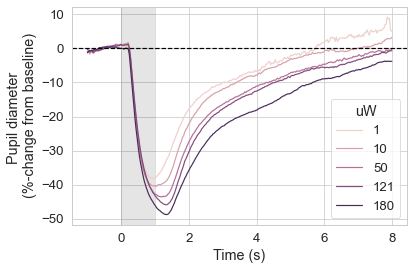

In [19]:
pal = sns.cubehelix_palette(n_colors=10, as_cmap=False)
data = neuroptics.loc[((neuroptics.Subject=='sub001'))]
data = data.set_index(['rec','onset'])
baselines = data.loc[data.index.get_level_values(1) <= 0].mean(level=0)
data['pupil_pc'] = ((data.pupil / baselines.pupil) - 1) * 100
data = data.groupby(['uW', 'onset']).mean()
ax = sns.lineplot(data=data, x='onset', y='pupil_pc', hue='uW', palette=pal[0:-1:2])
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)');

In [20]:
data

pupil  valid  pupil_pc
uW  onset                           
1   -1.000  5.67400    1.0 -1.362406
    -0.967  5.72040    1.0 -0.557683
    -0.933  5.70240    1.0 -0.891712
    -0.900  5.68400    1.0 -1.200847
    -0.866  5.69720    1.0 -0.969958
...             ...    ...       ...
180  7.857  5.24360    1.0 -3.722634
     7.890  5.24095    1.0 -3.782418
     7.924  5.24060    1.0 -3.784369
     7.957  5.23930    1.0 -3.813647
     7.991  5.24005    1.0 -3.791999

[1350 rows x 3 columns]

In [21]:
data.to_csv('./neuroptics_intensity_averages.csv')

In [22]:
import os
import os.path as op
import pandas as pd

datapath = r'../examples/PFR/data/pyplr_intensities'
subs = os.listdir(datapath)
cols = ['diameter','diameter_3d','timestamp','confidence']
trials=[]
for sub in subs:
    subpath = op.join(datapath, sub)
    for rec in os.listdir(subpath):
        recpath = op.join(subpath, rec)
        data = pd.read_csv(op.join(recpath, 'raw_data.csv'), index_col='timestamp', usecols=cols)
        data['onset'] =  range(len(data))
        data['onset'] =  data['onset'] * 1/120-1
        data['Subject'] = sub
        data['rec'] = rec
        trials.append(data.reset_index())
        
trials = pd.concat(trials).reset_index(drop=True).rename(columns={'index':'onset'})
trials = trials.sort_values(['Subject','rec'])
trials['uW'] = trials.Subject.str.strip('JTM')
trials

FileNotFoundError: [Errno 2] No such file or directory: '../examples/PFR/data/pyplr_intensities'

In [ ]:
pal = sns.cubehelix_palette(n_colors=16, as_cmap=False)
trials = trials.groupby(['uW','onset']).mean()
baselines = trials.loc[trials.index.get_level_values(1) <= 0].mean(level=0)
trials['pupil_pc'] = ((trials['diameter_3d'] / baselines['diameter_3d']) - 1) * 100
trials = trials.sort_index(level=0)
ax = sns.lineplot(data=trials, x='onset', y='pupil_pc', hue='uW', hue_order=['1.5', '10', '50', '121', '180'], palette=pal[2:-1:3])
ax.axvspan(0, 1, color='k', alpha=.1)
ax.axhline(0, 0, 1, color='k', ls='--')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Pupil diameter \n(%-change from baseline)');



In [ ]:
trials.to_csv('../data/STLAB_match_PLRs.csv')

In [ ]:
baselines = trials.loc[trials.index.get_level_values(1) <= 0].mean(level=0)
baselines

In [ ]:
trials